Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist


# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $$\mathbf{x} \in \mathbb{R}^2$$.

The first one is a "simple" set of features, with just the two input features plus an intercept:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ]
\end{align*}$$

The second is up to you! For example, you could consider a set of quadratic polynomial features,

$$\begin{align*}
\phi_{\text{quadratic}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2 ].
\end{align*}$$

This example just includes quadratic terms, but you could also include higher order polynomial terms (e.g. $x_1^3, x_2^3$) or completely different features alltogether. It's up to you — but you should be prepared to justify your choice!

You will also fit the model in two different ways:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

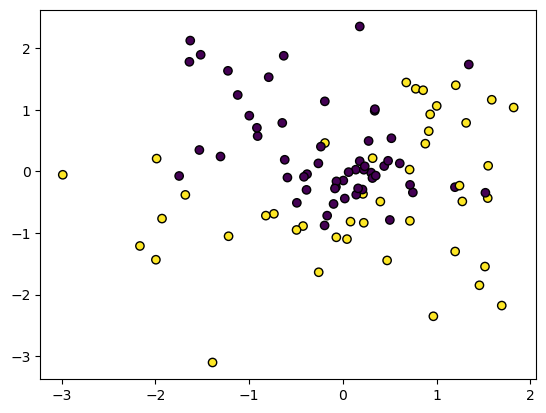

In [4]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "quadratic" one.

They define feature spaces in $\mathbb{R}^3$ and $\mathbb{R}^6$, respectively.

In [41]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_quadratic(X):
    interactions = X.prod(-1, keepdim=True)
    
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), interactions), -1)

Dimension of Phi, `features_simple`: torch.Size([100, 3])
tensor([[ 7.8630e-02],
        [-6.7190e-01],
        [-4.9078e-02],
        [-6.7402e-02],
        [-7.8820e-02],
        [-6.3517e-03],
        [-4.1125e-01],
        [-1.3899e+00],
        [-3.0771e-01],
        [-2.3450e+00],
        [ 2.0279e-02],
        [-2.5642e-01],
        [ 4.2564e-01],
        [ 2.7882e-01],
        [ 1.4004e-01],
        [ 1.7061e-01],
        [ 3.8322e-03],
        [ 5.9851e-01],
        [ 2.9880e-02],
        [-7.8297e-04],
        [ 1.4792e+00],
        [ 1.0356e+00],
        [ 1.6637e-01],
        [-2.8861e-01],
        [ 3.3463e-01],
        [-6.8376e-01],
        [-1.5599e+00],
        [ 5.2174e-02],
        [ 5.0648e-01],
        [ 6.8043e-02],
        [-8.7743e-02],
        [ 1.8896e+00],
        [ 1.2001e-01],
        [ 1.8590e-02],
        [ 1.7244e-02],
        [-1.9641e-01],
        [-3.4558e+00],
        [-3.4397e-02],
        [-2.2738e+00],
        [ 4.2111e-01],
        [-2.8704e+00],

# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [6]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [7]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a torch scalar
        
    """
    var = sigma**2
    log_prior_w = dist.MultivariateNormal(loc=torch.zeros(Phi.shape[-1]), covariance_matrix=var*torch.eye(Phi.shape[-1]) ).log_prob(w)
    
    y_hat = predict_probs_MAP(Phi,w)
    log_prob_y = torch.FloatTensor(sum([dist.Bernoulli(torch.FloatTensor.float((y_hat[i]))).log_prob(torch.FloatTensor.float( y[i]),  ) for i in range(len(y_hat))]) )

    return log_prob_y + log_prior_w
    

In [8]:
# (GRADING)

In [9]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.

Also, **your code should work for ANY features!**. We will test this out on not just the "simple" and "quadratic" features above, but also on your own custom choice of features.

In [10]:

def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.ones(size=(Phi.shape[-1],)).requires_grad_(True)
    #weights = torch.tensor( weights_dist.sample((Phi.shape[-1],)), requires_grad=True )
    
    losses = []
    
    epochs = 300
    optimizer = torch.optim.SGD((weights, Phi, y), lr=0.01, momentum=0.3)
    
    for i in range(epochs):
        optimizer.zero_grad()
        # forward pass
        loss = -log_joint(Phi, y, weights)
        # backward pass
        loss.backward()
        optimizer.step()            
        losses.append( loss.item())
    
    return weights.detach(), losses



### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

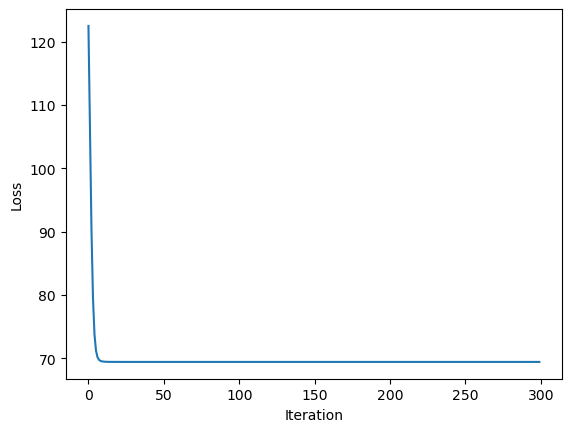

In [11]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [12]:
losses[-1]

69.42093658447266

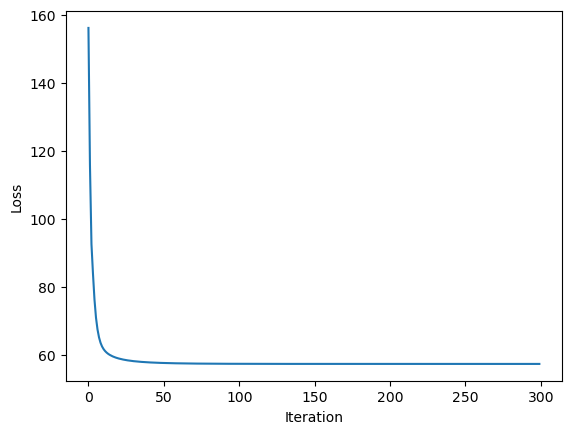

In [13]:
w_MAP_quad, losses = find_MAP(features_quadratic(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [14]:
losses[-1]

57.411376953125

In [15]:
# (GRADING)

In [16]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [17]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


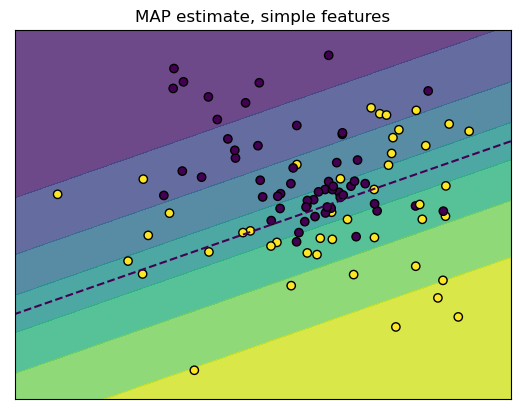

In [18]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


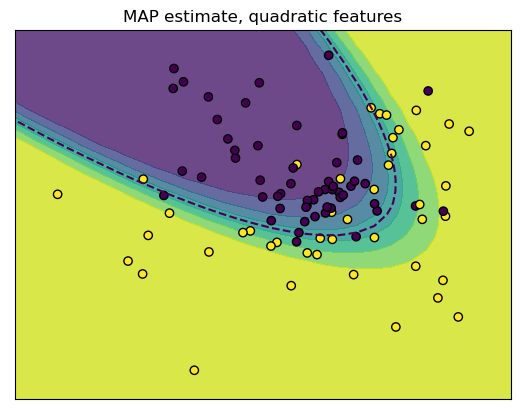

In [19]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))
plt.title("MAP estimate, quadratic features")
train_accuracy = (predict_probs_MAP(features_quadratic(X_train), w_MAP_quad).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_quadratic(X_test), w_MAP_quad).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [20]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
        """
        Compute the Laplace approximation of the posterior covariance 
        in a logistic regression setting.

        INPUT:
        Phi   : (N, D) tensor of input features, where N is the number of 
                observations and D is the number of features
        y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
                containing zeros and ones
        w_MAP : (D,) vector of optimized weights, at a mode of the target density
        sigma : scalar, standard deviation of Gaussian prior distribution p(w).
                Leave this set to sigma=10 for purposes of this exercise

        OUTPUT:
        Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
                approximation
        """

     
        prior_precision_matrix = (1/(prior_std**2))*torch.eye(Phi.shape[-1])
        
        
        d = w_MAP.shape[0]

        y_hat = predict_probs_MAP(Phi, w_MAP)
        sigma = torch.tensor( sum ( [ ( y_hat[i] * (1 - y_hat[i]) )  * ( Phi[i].reshape(d,1) @ Phi[i].reshape(1,d) )  for i in range(len(y)) ] ) )
        
        # Sn^(-1) = - H = -(∂/∂w)*(∂/∂w)logP(w|D)
        neg_hessian = prior_precision_matrix + sigma
        
        cov = torch.linalg.inv(neg_hessian) 

        return cov


In [21]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_23698/1259258092.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor( sum ( [ ( y_hat[i] * (1 - y_hat[i]) )  * ( Phi[i].reshape(d,1) @ Phi[i].reshape(1,d) )  for i in range(len(y)) ] ) )


In [22]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    n_samples = 10000
    w_dist = dist.MultivariateNormal(loc=w_MAP, covariance_matrix=Cov)
    w_samples = w_dist.sample((n_samples,))
    n = Phi.shape[0]
    samples_stack = torch.hstack([predict_probs_MAP(Phi, w_samples[i]).reshape(n,1) for i in range(n_samples)])

    return torch.mean(samples_stack, axis=1)

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [23]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)
Cov_simple

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_23698/1259258092.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor( sum ( [ ( y_hat[i] * (1 - y_hat[i]) )  * ( Phi[i].reshape(d,1) @ Phi[i].reshape(1,d) )  for i in range(len(y)) ] ) )


tensor([[ 0.0490, -0.0042,  0.0058],
        [-0.0042,  0.0579, -0.0116],
        [ 0.0058, -0.0116,  0.0726]])

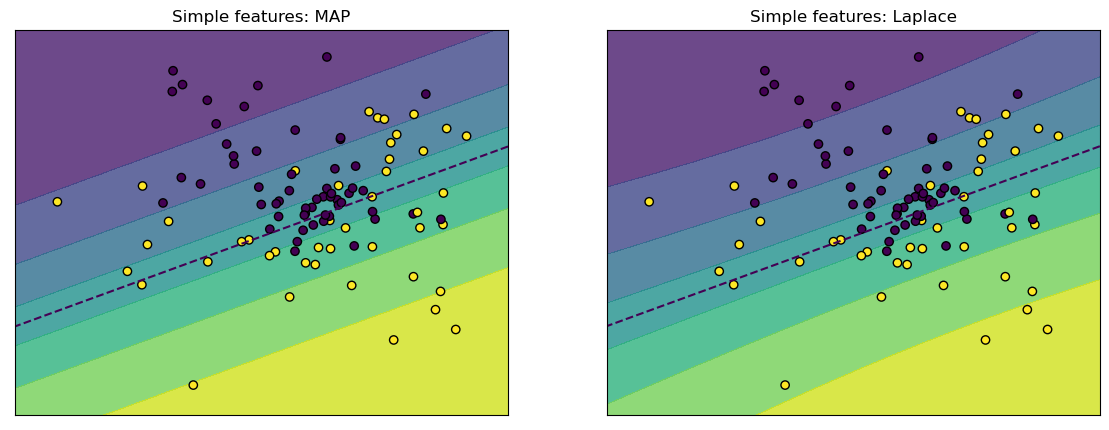

In [24]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [25]:
Cov_quad = compute_laplace_Cov(features_quadratic(X_train), y_train, w_MAP_quad)

/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_23698/1259258092.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor( sum ( [ ( y_hat[i] * (1 - y_hat[i]) )  * ( Phi[i].reshape(d,1) @ Phi[i].reshape(1,d) )  for i in range(len(y)) ] ) )


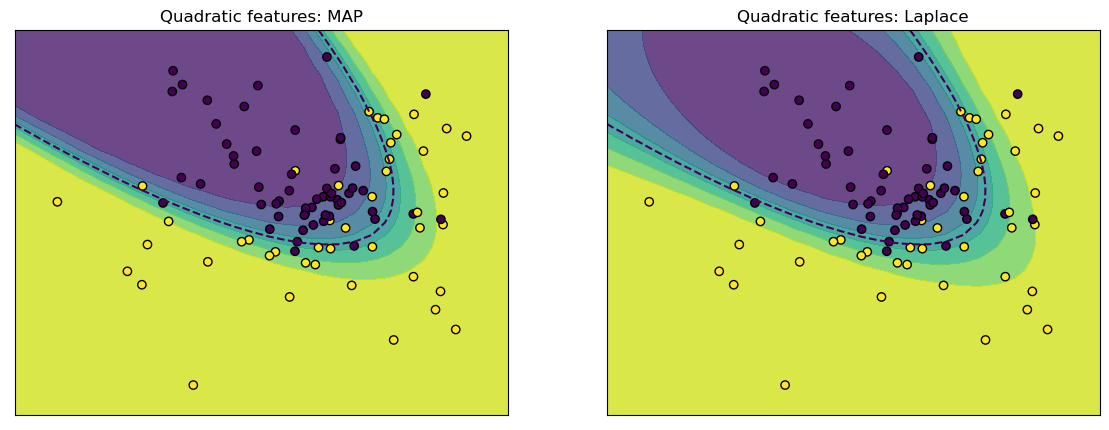

In [26]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Quadratic features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_quadratic(X), w_MAP_quad))

plt.subplot(122)
plt.title("Quadratic features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_quadratic(X), w_MAP_quad, Cov_quad))

In [27]:
# (GRADING)

In [28]:
# (GRADING)

In [29]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [39]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
        """
        This computes the Laplace approximation to the marginal likelihood,
        as defined in the Week 5 lectures.

        INPUT:
        Phi   : (N, D) tensor of input features, where N is the number of 
        observations and D is the number of features
        y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
        containing zeros and ones
        w_MAP : (D,) vector of optimized weights, at a mode of the target density
        Cov   : (D, D) approximate posterior covariance matrix

        OUTPUT:
        log_evidence : scalar value estimating `log p(y | Phi)`
        """
        log_const = torch.log( torch.pow( 2 * torch.pi, torch.FloatTensor( [w_MAP.shape[0]/2 ]) ) / torch.sqrt(torch.linalg.det(torch.linalg.inv(Cov)) ))
                        
        prob_joint = log_joint(Phi, y, w_MAP)

        return  prob_joint + log_const
    
    

In [40]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_quadratic(X_train), y_train, w_MAP_quad, Cov_quad).item())

Model evidence estimate (simple features): -70.93086242675781
Model evidence estimate (polynomial features): -57.525352478027344


In [32]:
# (GRADING)

# TASK #5 (2 points + 4 points): Define your own feature space

Your next task is to define your own, custom feature space! This can be practically any deterministic function from $\mathbb{R}^2$ to $\mathbb{R}^D$, and you even get to pick the dimensionality $D$.

In the following cells, you first define your feature space, and then we estimate the posterior using your code above. We report training accuracy, test accuracy, and model evidence, as well as plot the decision boundaries.

Feel free to get quite creative here! However, you will be asked to defend your choice of feature space in the free-answer section at the bottom.

**Make sure when you submit, you include whatever you consider the "best" possible choice!**

In [467]:
def features_student(X):
    """
    Compute your own, custom set of features!
    
    INPUT:
    X      : (N, 2) tensor of raw input data
    
    OUTPUT:
    Phi    : (N, D) tensor of transformed inputs
    """
    X_sin = torch.sin(X)
    X_cos = torch.cos(X)
    X_cubed = X.pow(3)
    interactions = X.prod(-1, keepdim=True)
    X_cubed_norm = (X_cubed - torch.mean(X_cubed)) / torch.std(X_cubed)
    
    return torch.concat((torch.ones_like(X[:,:1]),
                         interactions,
                         X_sin, 
                         X_cos,
                         X_sin*X_cos,
                         X_cubed_norm*X_cos,
                        ), -1)
    
    
    

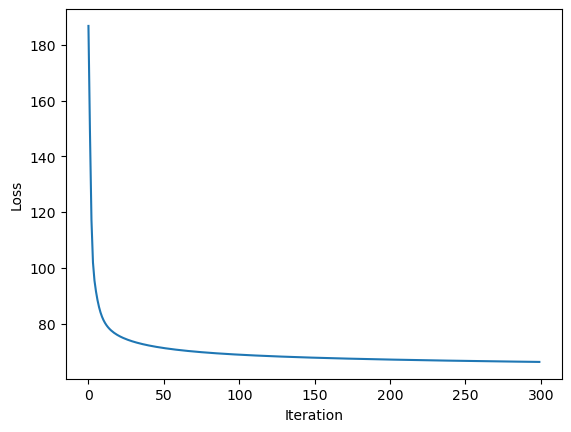

In [468]:
w_MAP_student, losses = find_MAP(features_student(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [474]:
train_accuracy = (predict_probs_MAP(features_student(X_train), w_MAP_student).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_student(X_test), w_MAP_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

train_accuracy = (predict_bayes(features_student(X_train), w_MAP_student, Cov_student).round() == y_train).float().mean()
test_accuracy = (predict_bayes(features_student(X_test), w_MAP_student, Cov_student).round() == y_test).float().mean()
print("YOUR features! Training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))


YOUR features! Training accuracy = 0.88, test accuracy = 0.94


/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_23698/1259258092.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor( sum ( [ ( y_hat[i] * (1 - y_hat[i]) )  * ( Phi[i].reshape(d,1) @ Phi[i].reshape(1,d) )  for i in range(len(y)) ] ) )


YOUR features! Training accuracy = 0.88, test accuracy = 0.94


In [470]:
Cov_student = compute_laplace_Cov(features_student(X_train), y_train, w_MAP_student)

print("YOUR features! Model evidence estimate:",
      compute_laplace_log_evidence(features_student(X_train), y_train, w_MAP_student, Cov_student).item())

YOUR features! Model evidence estimate: -56.30231475830078


/var/folders/3f/5b_39xqs2tlgzd30m4ll014r0000gn/T/ipykernel_23698/1259258092.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor( sum ( [ ( y_hat[i] * (1 - y_hat[i]) )  * ( Phi[i].reshape(d,1) @ Phi[i].reshape(1,d) )  for i in range(len(y)) ] ) )


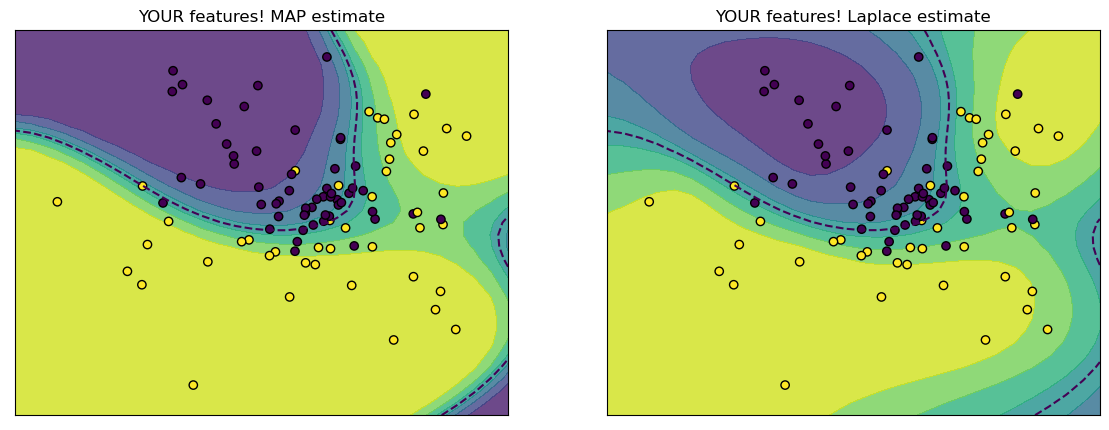

In [471]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("YOUR features! MAP estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_student(X), w_MAP_student))

plt.subplot(122)
plt.title("YOUR features! Laplace estimate")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_student(X), w_MAP_student, Cov_student))

# Please answer the following short questions:

1. *[Feature selection]* How did you choose your features? Name at least two ways of comparing whether one set of features is "better" than another. Would these methods generally yield the same "ranking" of different features? Why or why not?

2. *[Overfitting]* Is "overfitting" possible in this setting? Did you experience it? If so, how would you detect it? Does using the Laplace approximation "help" with overfitting, or does it not make a difference? Justify your answer.

**Q1:** 
  
I based my decision on the notion that radial functions make for good features as seen in class. Also, the sine and cosine are orthogonal inner products so they are not redundant features, and neither are their product. To account for the fact that the data is not completely "radial" I added a bias term, the interactions term between $X_{1}X_{2}$, and a cubed term for $X_{1} \text{ and } X_{2}$ to account for a variety of linear properties.

To compare whether one feature set is better than another, we can look at the test score and the training score. We can look at the feature sets' training scores and test scores. If one feature set yields a very good training score but a low test score whereas the other yields a fairly good training score but an excellent test score, we can fairly assume that the latter model generalizes better on the data, and thus is the better feature set of the model. Also, in the integration of Bayesian techniques, we can look at the model evidence. If the posterior probability is higher for one feature set compared to another, it is presumed it makes a better inference on the data set. 

**Q2:**
  
When choosing features, we can always be prone to overfitting a model. In Bayesian optimization, we put some trust into our prior. It depends on how accurate our prior is as it is part of normalizing our posterior. If we choose a well-suited prior, the Bayesian model is robust towards overfitting issues. We can always look at the decision boundary and determine how well the model generalizes. Typically, both MAP estimates and Laplace approximations are robust against overfitting if the prior is carefully chosen. However, the model complexity can lead to it happening. The Occam Factor is trying to correct for unlikely explanations and thus reduce its overfitting issues.

In my case, the feature set seems to generalize quite well in the high-density region where the data is located. However, it has a decision boundary for the purple dots in the bottom right corner. Based on the distribution of the purple dots, it seems highly unlikely that they are to occur in this region as the only points close to it are yellow. The way we detect overfitting is generally by looking at the training score relative to the test score. Usually, we want the test score to be equal to or higher than the training score to say our model generalizes well. Indeed, that is the case for my model. Therefore, it is fair to say it generalizes in a good manner. Still, the low-right corner is a result of overfitting the decision boundary, presumably a result of our prior estimate. 

The Laplace approximation generally captures the high-density regions and gives less probability to its variance. Thus, we get a more narrow density function centered at its mode. However, the Bayesian Information Criterion is both in place for MAP estimates and Laplace, so when increasing the model parameters we can result in overfitting issues by increasing the likelihood with many parameters. Thus, it does not necessarily help deduce overfitting issues. In my case, it seems that the decision boundary in the lower right corner is less visible so that it may suggest an improvement in the case of overfitting. Thus, it is an improvement, but it is still present. 

#### Ignore the following cells. They are used by the grading system.

In [ ]:
# (GRADING)

In [ ]:
# (GRADING)

In [ ]:

N = 200
D = 12
Phi = torch.rand(N,D)
S = torch.rand(D, D)
# Phi.T S Phi efficient computation

# Method 1: ((Phi @ S) * Phi).sum(1)
# Method 2: S[:,:,None] --> (3,3,1)
# Method 3: torch.einsum('ij, jk, ik->i', Phi, S, Phi)
